## Customising the environment class - Timing and plotting results

Beside the action and observation spaces (see example 3), the timing between fmu timestep, the interval between two agent actions and the resolution of external data is something that could be necessary to customize.

Like in example 3, the energy managenment of a DC microgrid is chosen. The microgrid consist of a PV array, a battery storage, a load and a grid connection. The main idea is to optimise the use of the battery storage to minimise the energy consuption from the main grid and maximise the use of the PV energy. As basis of this example, the same customised environment with the reduced action and observation spaces is used. So the environment definition is imported from an external file, for details see example 3. 

The fmu (see config file 03/04) has a base time step of 0.01 seconds which is very short but necessary to simulate all dynamic effects. It isn't realistic that the agent will take an action every 10 ms, so this time shall be changed to an action every ten seconds. Also, the simulation time is changed to ten minutes. This is updated in the config file for this example (04-config.cfg).

```
[FMU]
FMU_path = 03-MicrogridFMU.fmu
stop_time = 600.0
dt = 0.01
action_interval = 10.0
```

All data handling and simulations necessary between two action steps are done by the StableRLS package. Only the timing of external inputs needs to handled manually. For this, the pre-defined function *FMU_external_input* is modified. 

In addition to this, the *export_results* function of the environment is modified to get automated result plots.

In [15]:
# import packages as in the other examples
import stablerls.configreader as cfg_reader
import gridEnv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

class GridEnv2(gridEnv.GridEnv):
    def FMU_external_input(self):
        """This function is called before each FMU step. Here external FMU
        inputs independent of the agent action are set. In this case, this includes
        weather data and the load power.

        Use the code below to access the FMU inputs.
        self.fmu.fmu.setReal([self.fmu.input[0].valueReference], [value])
        """
        # Irradiance
        self.fmu.fmu.setReal([self.fmu.input[1].valueReference], [1000.0])

        # ModuleTemperature
        self.fmu.fmu.setReal([self.fmu.input[0].valueReference], [30.0])

        # LoadPower
        self.fmu.fmu.setReal([self.fmu.input[2].valueReference], [500.0])

    def export_results(self):
        """This function plots part of the external inputs, the agent actions and 
        the main outputs."""

        # plot external inputs
        figIrr, axsIrr = plt.subplots(1,1)
        axsIrr.plot(self.times, self.inputs[:,1])
        axsIrr.set_title("PV Irradiance")
        axsIrr.set_xlabel("Time in s")
        axsIrr.set_ylabel("Irradiance in W/m^2")
        figIrr.canvas.draw()
        figIrr.show()

        figLoad, axsLoad= plt.subplots(1,1)
        axsLoad.plot(self.times, self.inputs[:,2])
        axsLoad.set_title("Load Power")
        axsLoad.set_xlabel("Time in s")
        axsLoad.set_ylabel("Power in W")
        figLoad.canvas.draw()
        figLoad.show()

        # plot agent actions
        figAct, axsAct = plt.subplots(1,1)
        line1, line2, = axsAct.plot(self.times, self.inputs[:,3],self.times, self.inputs[:,5])
        axsAct.legend([line1, line2],["Battery", "Grid"])
        axsAct.set_title("Voltage References")
        axsAct.set_xlabel("Time in s")
        axsAct.set_ylabel("Voltage in V")
        figAct.canvas.draw()
        figAct.show()
        
        # plot outputs (voltages/source currents)
        figOutV, axsOutV = plt.subplots(1,1)
        line3, line4, line5, line6, = axsOutV.plot(self.times,self.outputs[:,0],self.times,self.outputs[:,3],self.times,self.outputs[:,6],self.times,self.outputs[:,13])
        axsOutV.legend([line3, line4, line5, line6],["PV", "Grid","Load","Battery"])
        axsOutV.set_title("Voltages")
        axsOutV.set_xlabel("Time in s")
        axsOutV.set_ylabel("Voltage in V")
        figOutV.canvas.draw()
        figOutV.show()

        figOutI, axsOutI = plt.subplots(1,1)
        line7, line8, line9, = axsOutI.plot(self.times,self.outputs[:,2],self.times,self.outputs[:,5],self.times,self.outputs[:,12])
        axsOutI.legend([line7, line8, line9],["PV", "Grid", "Battery"])
        axsOutI.set_title("Source Currents")
        axsOutI.set_xlabel("Time in s")
        axsOutI.set_ylabel("Current in A")
        figOutI.canvas.draw()
        figOutI.show()
        
        # plot SOC
        figBat, axsBat = plt.subplots(1,1)
        axsBat.plot(self.times,self.outputs[:,11])
        axsBat.set_xlabel("Time in s")
        axsBat.set_ylabel("SOC")
        axsBat.set_title("SOC")
        figBat.canvas.draw()
        figBat.show()

With this modified environment class ten minutes are simulated.

In [16]:
# read config-file
config = cfg_reader.configreader('04-config.cfg')

# create new env object and reset it before simulating
microgrid = GridEnv2(config)
obs = microgrid.reset()

# for this example, the actions are kept constant at the reference value of 48 V
action = np.array([5,5])

terminated = False
truncated = False
while not (terminated or truncated):
    observation, reward, terminated, truncated, info  = microgrid.step(action)
    print(f'Action: {action}\nObservation: {observation}\n')

microgrid.close()

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 -0.03  0.22]

Action: [5 5]
Observation: [ 0.12  0.04 -0.02  0.04  0.48 -0.03 

With the newly defined *export_results* function it is possible to generate automated plots of the results:

C:\Users\cfn2169\AppData\Local\Temp\ipykernel_17300\3759677851.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figIrr.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_17300\3759677851.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figLoad.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_17300\3759677851.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figAct.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_17300\3759677851.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figOutV.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_17300\3759677851.py:74: UserWarning: Matplot

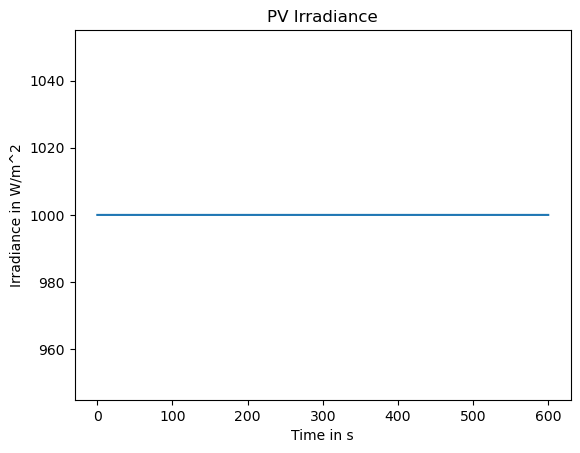

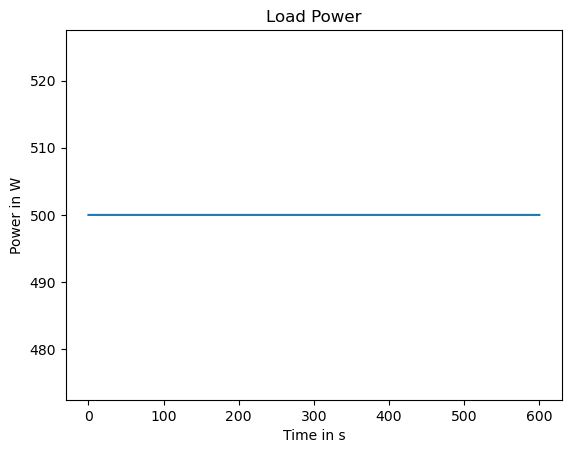

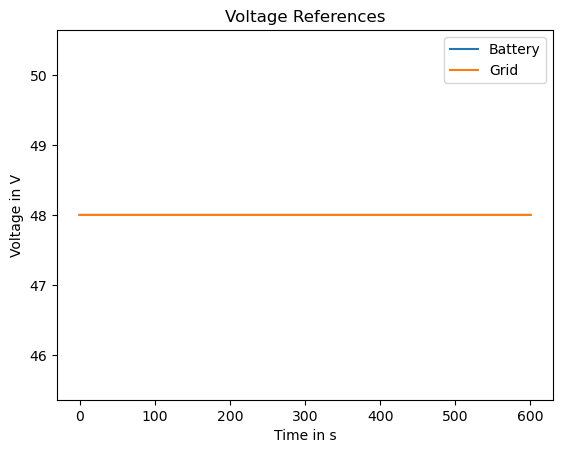

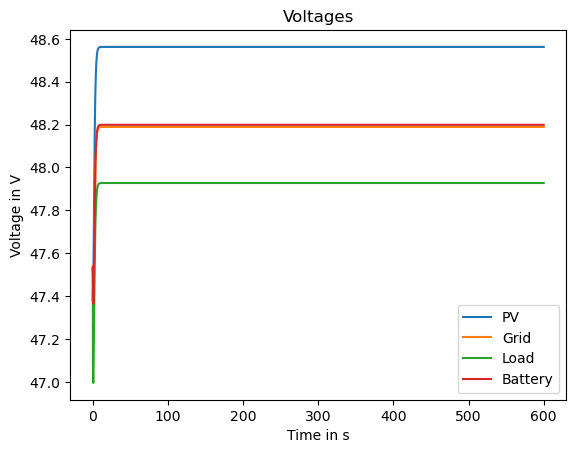

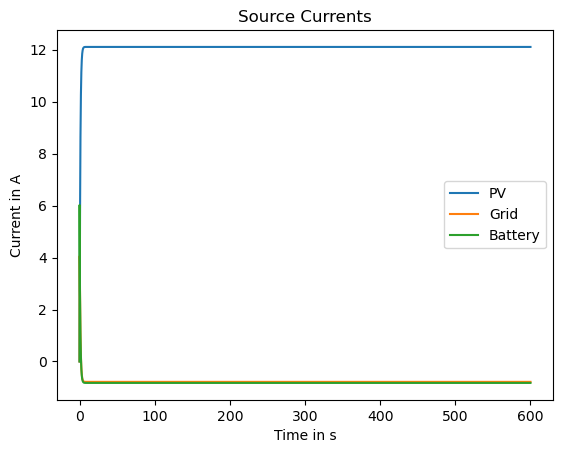

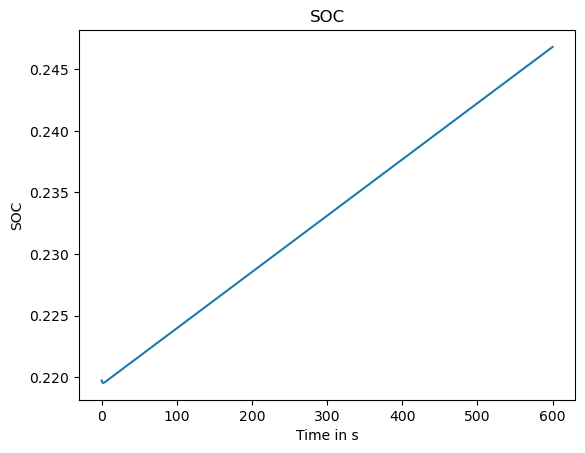

In [17]:
microgrid.export_results()